In [1]:
import pandas as pd
import numpy as np
from time import time
from data.data import load_data
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import accuracy_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
# TODO fill this cell out

# Give this run a title
run = 'capsnet_15+recnn_no_aug'

# Add validation files
recnn_with_val = pd.read_csv('./predictions/validation_recnn_augmentation_5epochs.csv')
recnn_no_val = pd.read_csv('./predictions/validation_recnn_no_augmentation_5epochs.csv')
datas = [recnn_with_val, recnn_no_val]

# Add test files
capsnet_test = pd.read_csv('./predictions/test_capsnet_15epochs.csv')
recnn_test = pd.read_csv('./predictions/test_recnn_no_augmentation.csv')
tests = [capsnet_test, recnn_test]

In [ ]:
# Create x and y datasets
x_total_train = np.stack(([x['prediction'] for x in datas]), axis=1)
_, (_, y_pred_val, _), _ = load_data()
y_total_train = np.ravel(y_pred_val)
x_train, x_valid, y_train, y_valid = train_test_split(x_total_train, y_total_train)

# Create x testset
x_test = np.stack(([x['prediction'] for x in tests]), axis=1)

In [4]:
# Correlation matrix on validation files
predictions = {'recnn_with_val': recnn_with_val['prediction'],
              'recnn_no_val': recnn_no_val['prediction']}
df_predictions = pd.DataFrame(data=predictions) 
print(df_predictions)
df_predictions.corr()

       recnn_with_val  recnn_no_val
0            0.055403      0.023356
1            0.710628      0.727544
2            0.998516      0.999013
3            0.132898      0.166737
4            0.386734      0.109362
5            0.111145      0.035985
6            0.960908      0.827009
7            0.789955      0.384791
8            0.810465      0.439907
9            0.879033      0.942454
10           0.450621      0.195614
11           0.996532      0.958564
12           0.995516      0.916550
13           0.026389      0.008990
14           0.968775      0.913299
15           0.969095      0.242576
16           0.993594      0.330594
17           0.499537      0.054772
18           0.021203      0.005226
19           0.109803      0.118720
20           0.844206      0.687592
21           0.711098      0.352679
22           0.944874      0.984347
23           0.996091      0.561615
24           0.367634      0.165262
25           0.835607      0.898551
26           0.011978      0

,recnn_with_val,recnn_no_val
recnn_with_val,1.000000,0.860821
recnn_no_val,0.860821,1.000000


In [23]:
# Correlation matrix on test files
predictions = {'capsnet_test': capsnet_test['prediction'],
              'recnn_test': recnn_test['prediction']}
df_predictions = pd.DataFrame(data=predictions) 
print(df_predictions)
df_predictions.corr()

       capsnet_test  recnn_test
0          0.029178    0.033336
1          0.907967    0.886647
2          0.144129    0.837238
3          0.994295    0.998243
4          0.818221    0.444659
5          0.051123    0.154733
6          0.823591    0.820602
7          0.925199    0.766559
8          0.992223    0.947977
9          0.022722    0.136316
10         0.932151    0.812460
11         0.039872    0.019377
12         0.991304    0.999999
13         0.992727    0.999943
14         0.046677    0.383871
15         0.029529    0.120907
16         0.304270    0.558578
17         0.934351    0.611232
18         0.327635    0.078943
19         0.817651    0.079178
20         0.454540    0.161669
21         0.025928    0.076034
22         0.218414    0.094110
23         0.025562    0.125849
24         0.018043    0.004660
25         0.169356    0.540050
26         0.964619    0.890994
27         0.024576    0.072558
28         0.992779    0.999993
29         0.234256    0.171548
...     

,capsnet_test,recnn_test
capsnet_test,1.000000,0.790768
recnn_test,0.790768,1.000000


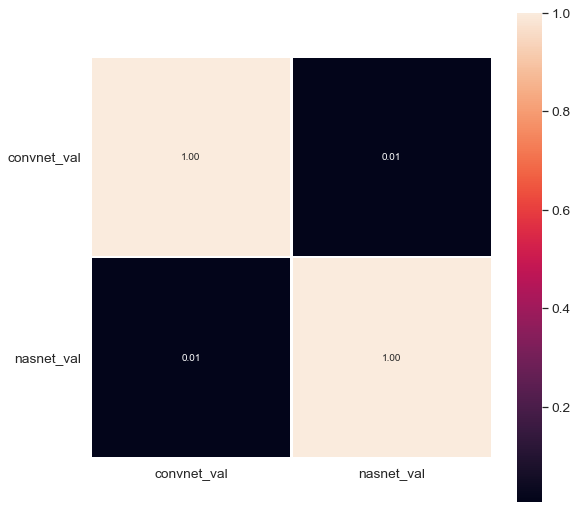

In [13]:
# Plot correlations
plt.figure(figsize=(9, 9))
sns.set(font_scale=1.25)
sns.heatmap(df_predictions.corr(), linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=df_predictions.columns , xticklabels=df_predictions.columns
            )
plt.yticks(rotation=0)
plt.show()

In [6]:
# Parameter tuning
xg_model = XGBRegressor(n_estimators=100, seed = 1234, objective='reg:squarederror')
param_dict = {'max_depth': [2,3,4],
              'min_child_weight': [3,4,5],
              'learning_rate': [0.1,0.15],
              'gamma': [0.2, 0.3, 0.4]
}

start = time()
grid_search = GridSearchCV(xg_model, param_dict, cv=5, verbose=1)
grid_search.fit(x_train, y_train)
print("GridSearch took %.2f seconds to complete." % (time()-start))
display(grid_search.best_params_)
best = grid_search.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  2.2min finished


GridSearch took 132.13 seconds to complete.


{'gamma': 0.4, 'learning_rate': 0.15, 'max_depth': 2, 'min_child_weight': 5}

In [7]:
# Fitting the model
xg_model = XGBRegressor(objective='reg:squarederror',
                        n_estimators = 1000,
                        learning_rate = best['learning_rate'],
                        max_depth = best['max_depth'],
                        min_child_weight = best['min_child_weight'],
                        gamma = best['gamma'],
                        seed = 1234)
start = time()
xg_model.fit(x_train, y_train)
xg_preds = xg_model.predict(x_valid)
print("Model took %.2f seconds to complete." % (time()-start))
print("RMSE: %.4f" % np.sqrt(mean_squared_error(y_valid, xg_preds)))

Model took 4.25 seconds to complete.
RMSE: 0.5001


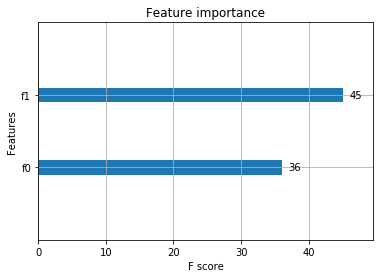

In [10]:
# Most important features (models)
plot_importance(xg_model)
plt.show()

In [24]:
# Train on whole dataset
xg_model_total = XGBRegressor(objective='reg:squarederror',
                        n_estimators = 1000,
                        learning_rate = best['learning_rate'],
                        max_depth = best['max_depth'],
                        min_child_weight = best['min_child_weight'],
                        gamma = best['gamma'],
                        seed = 1234)
xg_model_total.fit(x_total_train, y_total_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.4,
       importance_type='gain', learning_rate=0.15, max_delta_step=0,
       max_depth=2, min_child_weight=5, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=1234, silent=None, subsample=1, verbosity=1)

In [31]:
# Predict on model
xg_preds = np.expm1(xg_model_total.predict(x_test))
np.savetxt('./predictions/predictions_xgboost_ensemble'+run+'.csv', xg_preds, delimiter=",")